We start by importing the libraries we will need most.

In [1]:
"""Import libraries"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import scipy.stats as stats
from scipy.stats import chi2_contingency, pearsonr, fisher_exact

Now let us call up our dataset in csv, then get an idea of its structure by calling up the first five values, the datatypes present and the size of the dataset.  
The data represent video game sales statistics across several metrics: sales in North America, Europe, Japan, other regions and globally, as well as containing information on the year of publication and a ranking value.

In [2]:
"""Upload dataset"""
datavg = pd.read_csv('vgsales.csv')
datavg.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
"""Check shape dataset"""
datavg.shape 

(16598, 11)

In [4]:
"""Types check"""
datavg.dtypes

Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

# Preprocessing

We check for the presence of nulls

In [5]:
datavg.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [6]:
# Checks for duplicate rows in the entire DataFrame
datavg.duplicated().sum()

0

We replace the nulls in the 'Year' column with its mode. As the .mode() method can return more than one value we select the first one using .iloc[0].

In [7]:
mode_year = datavg['Year'].mode().iloc[0]

datavg['Year'] = datavg['Year'].fillna(mode_year)

We do the same with 'Publisher'

In [8]:
mode_publisher = datavg['Publisher'].mode().iloc[0] 

datavg['Publisher'] = datavg['Publisher'].fillna(mode_publisher)

There are no more null values.

In [9]:
datavg.isnull().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [10]:
print(datavg['Year'].dtype)

float64


We turn 'Year' into an integer, converting it into a datetime object and specifying the representation as a four-digit number. We then extract only the year part, cutting out months and days, and apply this to the 'Year' column
 

In [11]:
datavg['Year'] = pd.to_datetime(datavg['Year'], format='%Y')
datavg['Year'] = datavg['Year'].dt.year
# Check the data type of the 'Year' column after conversion
print(datavg['Year'].dtype)

int32


In [12]:
datavg.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Study of indices and statistical tests

We study the position and shape indices

In [13]:
desc = datavg.describe()

# Conversion of skewness and kurtosis in DataFrame to facilitate merging
numeric_cols = datavg.select_dtypes(include=[np.number]).columns
skewness_df = pd.DataFrame(datavg[numeric_cols].skew(), columns=['skewness']).T
kurtosis_df = pd.DataFrame(datavg[numeric_cols].kurt(), columns=['kurtosis']).T

# Union of descriptive statistics with skewness and kurtosis using pd.concat
desc_extended = pd.concat([desc, skewness_df, kurtosis_df])

# Print statistics, now including skewness and kurtosis
desc_extended

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.448789,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.790533,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000
skewness,0.000066,-1.026438,18.799627,18.875535,11.206458,24.233923,17.400645
kurtosis,-1.199865,1.927300,649.130268,756.027796,194.233994,1025.348145,603.932346


Sales per region
- North America (NA_Sales) has on average the highest sales per game (0.265 million units). This suggests that North America may be the largest or most profitable market for video games among those considered.
- Sales in Europe (EU_Sales) and Japan (JP_Sales) are significantly different, with Europe having almost twice the average sales of Japan (0.147 vs. 0.078 million units). This could reflect differences in cultural preferences, population density, or the availability and accessibility of video games.
- Other Sales (Other_Sales) has the lowest average (0.048 million units), indicating that other markets combined contribute less to total sales than the top three regions.


Trend over time
- The time range of the data extends from 1980 to 2020, with an average around 2006. This suggests that the dataset spans several generations of game systems, from old-school consoles to modern gaming platforms.
- The distribution of release dates indicates that most games were released during the second half of the period under investigation, with median and third quartile indicatively between 2007 and 2010. This could suggest an acceleration in the video game industry in terms of the number of titles released per year, potentially driven by factors such as the advancement of technology, the rise in popularity of video games and the expansion of global markets.

Kurtosis
- Year: With a kurtosis of 1.927300, it can be guessed that there is more data concentrated around the mean and heavier tails than a normal distribution, suggesting publication peaks in specific years.
- Sales: All sales columns (NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales) show extremely high kurtosis values, indicating very sharp distributions with heavy tails. This suggests that most games sell very little, but there are some exceptions that sell extraordinary amounts

Skewness
- Year: The skewness of -1.026438 emphasises a bias towards lower values, suggesting that there were more launches in the last few dates than in the initial years covered by the data.
- Sales: The sales columns all show very high skewness, indicating a significant bias towards lower values. This confirms that most games sell in limited quantities, with a few outliers representing very high sales.

"We evaluate the normality of distributions with a Shapiro-Wilk test"

In [14]:
import pandas as pd
from scipy.stats import shapiro

# Assuming df is your DataFrame

# Definition of the shapiro_test function
def shapiro_test(data, col_name):
    stat, p_value = shapiro(data[col_name])
    print(f"Column {col_name}: Statistics={stat}, P-value={p_value}")
    
    # Interpretation of P-value
    alpha = 0.05
    if p_value > alpha:
        print('Distribution appears Gaussian (fail to reject H0)')
    else:
        print('Distribution does not appear Gaussian (reject H0)')
    print() # Empty line for better readability
    
# Execute Shapiro-Wilk test on all numeric columns of the DataFrame
for col in datavg.select_dtypes(include=['float64', 'int64']).columns:
    shapiro_test(datavg, col)


Column Rank: Statistics=0.9549408831441059, P-value=7.398993110812134e-57
Distribution does not appear Gaussian (reject H0)

Column NA_Sales: Statistics=0.2673174949282279, P-value=1.7378441057088523e-121
Distribution does not appear Gaussian (reject H0)

Column EU_Sales: Statistics=0.2560020220066528, P-value=6.552018488250476e-122
Distribution does not appear Gaussian (reject H0)

Column JP_Sales: Statistics=0.24433707608762179, P-value=2.42986310320696e-122
Distribution does not appear Gaussian (reject H0)

Column Other_Sales: Statistics=0.20335217735185496, P-value=8.265248348373552e-124
Distribution does not appear Gaussian (reject H0)

Column Global_Sales: Statistics=0.2726659012978636, P-value=2.7686343674370784e-121
Distribution does not appear Gaussian (reject H0)



c:\Users\deimo\Desktop\Data Science\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16598.
  res = hypotest_fun_out(*samples, **kwds)


- The results clearly indicate that none of the distributions tested are Gaussian/normal. 

We continue with the Chi-Square Test, to test the independence between two variables.

In [15]:
import pandas as pd
from scipy.stats import chi2_contingency

# Definition of the chi_square_test function
def chi_square_test(data, col1, col2):
    crosstab = pd.crosstab(data[col1], data[col2])
    chi2_stat, p_value, dof, expected = chi2_contingency(crosstab)
    print(f'\nChi-square test between {col1} and {col2}:')
    print('Chi-square Statistic:', chi2_stat)
    print('P-value:', p_value)
    if p_value < 0.05:
        print("Result: There is a significant relationship.")
    else:
        print("Result: There is no significant relationship.")

# Calling the function for each pair of interest in datavg
chi_square_test(datavg, 'Platform', 'Genre')
chi_square_test(datavg, 'Platform', 'Publisher')
chi_square_test(datavg, 'Genre', 'Publisher')


Chi-square test between Platform and Genre:
Chi-square Statistic: 5909.978728846863
P-value: 0.0
Result: There is a significant relationship.

Chi-square test between Platform and Publisher:
Chi-square Statistic: 73675.2489644849
P-value: 0.0
Result: There is a significant relationship.

Chi-square test between Genre and Publisher:
Chi-square Statistic: 25511.254495343204
P-value: 0.0
Result: There is a significant relationship.


- There is a significant relationship between video game platforms and their genres. In other words, the probability of a certain video game genre appearing on a specific platform is not evenly distributed and is not independent of the type of platform.
- There is a significant relationship between video game platforms and the publishers that publish them. This suggests that certain publishers might prefer or have partnerships with specific platforms, or that certain platforms might attract specific publishers due to their target market or supported technologies.
- There is a significant relationship between the genres of video games and the publishers who publish them. This may imply that some publishers specialise or tend to publish video games in certain genres more frequently.

The Pearson correlation test is used to measure the strength and direction of the linear relationship between two continuous variables. In simpler terms, it helps to determine how closely two variables move together; whether as one variable increases, the other also increases (positive correlation), or as one increases, the other decreases (negative correlation).

In [16]:
def correlation_test(data, col1, col2):
    correlation_coef, p_value = pearsonr(data[col1], data[col2])
    print(f'Correlation between {col1} and {col2}:')
    print('Pearson Correlation Coefficient:', correlation_coef)
    print('P-value:', p_value)
    if p_value < 0.05:
        print("Result: The correlation is significant.\n")
    else:
        print("Result: The correlation is not significant.\n")

pairs_to_test = [
    ('Global_Sales', 'NA_Sales'),
    ('Global_Sales', 'Other_Sales'),
    ('Global_Sales', 'JP_Sales'),
    ('Global_Sales', 'EU_Sales'),
    ('Other_Sales', 'NA_Sales'),
    ('JP_Sales', 'NA_Sales'),
    ('EU_Sales', 'NA_Sales')
]

for col1, col2 in pairs_to_test:
    correlation_test(datavg, col1, col2)

Correlation between Global_Sales and NA_Sales:
Pearson Correlation Coefficient: 0.9410473571255502
P-value: 0.0
Result: The correlation is significant.

Correlation between Global_Sales and Other_Sales:
Pearson Correlation Coefficient: 0.7483308464078011
P-value: 0.0
Result: The correlation is significant.

Correlation between Global_Sales and JP_Sales:
Pearson Correlation Coefficient: 0.6118155181564499
P-value: 0.0
Result: The correlation is significant.

Correlation between Global_Sales and EU_Sales:
Pearson Correlation Coefficient: 0.9028358134817129
P-value: 0.0
Result: The correlation is significant.

Correlation between Other_Sales and NA_Sales:
Pearson Correlation Coefficient: 0.6347372719045483
P-value: 0.0
Result: The correlation is significant.

Correlation between JP_Sales and NA_Sales:
Pearson Correlation Coefficient: 0.44978740707039055
P-value: 0.0
Result: The correlation is significant.

Correlation between EU_Sales and NA_Sales:
Pearson Correlation Coefficient: 0.76772

**Global_Sales and NA_Sales:**

- Very high correlation (0.941), indicating a strong relationship between sales in North America and global sales. The North American market is a significant indicator of global performance.

**Global_Sales and Other_Sales:**

- High correlation (0.748), suggesting a significant relationship between global sales and sales in other regions outside the major markets. These "other" markets contribute to the global success of video games.

**Global_Sales and JP_Sales:**

- Moderate correlation (0.612), indicating that sales in Japan contribute to global success but to a lesser extent compared to other markets.

**Global_Sales and EU_Sales:**

- Very high correlation (0.903), showing that European sales are an important indicator of global sales, similar in importance to North American sales.

**Other_Sales and NA_Sales:**

- Moderate correlation (0.635), suggesting a link between sales in North America and sales in other markets.

**JP_Sales and NA_Sales:**

- Lower correlation (0.450), indicating a less direct link between success in Japan and that in North America.

**EU_Sales and NA_Sales:**

- High correlation (0.768), suggesting that what works well in the European and North American markets tends to correlate.

In general, sales performance in North America and Europe are particularly important for global success in the video game industry, while the Japanese market has a more moderate impact. These insights can be valuable for stakeholders in the video game industry when planning global launch and marketing strategies.


We use the ANOVA test to determine whether there are statistically significant differences between the averages.

In [17]:
from scipy.stats import f_oneway

def anova_test(data, independent_var, dependent_var):
    groups = data.groupby(independent_var)[dependent_var].apply(list)
    f_stat, p_value = f_oneway(*groups)
    print(f'ANOVA Test between {independent_var} for {dependent_var}:')
    print('F-statistics:', f_stat)
    print('P-value:', p_value)
    if p_value < 0.05:
        print("Result: There are significant differences.\n")
    else:
        print("Result: There are no significant differences.\n")

anova_test(datavg, 'Genre', 'Global_Sales')
anova_test(datavg, 'Platform', 'Global_Sales')
anova_test(datavg, 'Publisher', 'Global_Sales')

ANOVA Test between Genre for Global_Sales:
F-statistics: 18.218183813632834
P-value: 1.0627988216038264e-36
Result: There are significant differences.

ANOVA Test between Platform for Global_Sales:
F-statistics: 20.7009107095761
P-value: 2.3024481878272585e-109
Result: There are significant differences.

ANOVA Test between Publisher for Global_Sales:
F-statistics: 3.4009075307337904
P-value: 2.983039997997855e-138
Result: There are significant differences.



**ANOVA between 'Genre' and 'Global_Sales':**
   - The strong influence of game genre on global sales is highlighted through the ANOVA test. The high F-statistic and extremely low p-value effectively reject the null hypothesis, revealing that not all game genres perform equally in terms of global sales. This insight is particularly useful for developers in genre selection, reinforcing the need for strategic decision-making regarding which genres may align with their goals for market penetration and revenue maximization.

**ANOVA between 'Platform' and 'Global_Sales':**
   - The platform on which a game is released plays a crucial role in its global sales performance, as underscored by the ANOVA findings. The implications of this are twofold. Firstly, game developers need to closely consider their platform strategy, possibly focusing on platforms with a track record of higher sales. Secondly, for platform owners, understanding their position in the market can aid in tailoring their services to attract top-tier game developers, thereby creating a profitable symbiosis.

**ANOVA between 'Publisher' and 'Global_Sales':**
   - While the effect of the publisher on global sales might be less pronounced compared to genre and platform, it remains significant. This underscores the importance of publisher reputation, marketing prowess, and distribution networks in influencing a game's commercial success. Independent developers, in particular, might find these insights valuable when choosing between self-publishing and partnering with established publishers.

**General Conclusions:**
All three ANOVA tests resulted in extremely low p-values, well below any conventional significance level (like 0.05), providing strong evidence against the null hypothesis. This indicates significant differences in average global sales depending on the genre, platform, and publisher. These findings can provide valuable insights for video game developers and publishers in making decisions regarding game development and marketing strategies, considering how various categorical variables can influence the commercial success of a video game.


Let's perform a Wilcoxon Rank Sum (Mann-Whitney U Test) to compare average global sales according to genre, e.g. for Action games and sports games.

In [18]:
from scipy.stats import mannwhitneyu

# Select global sales data for games of genre "Action"
action_sales = datavg[datavg['Genre'] == 'Action']['Global_Sales']

# Select global sales data for games of genre "Sports"
sports_sales = datavg[datavg['Genre'] == 'Sports']['Global_Sales']

# Perform Mann-Whitney U Test
stat, p = mannwhitneyu(action_sales, sports_sales)

# Print the results
print('Wilcoxon Rank Sum (Mann-Whitney U Test) Results')
print(f'U Statistic: {stat}')
print(f'P-value: {p}')

if p < 0.05:
    print("There are significant differences.")
else:
    print("There are no significant differences.")

Wilcoxon Rank Sum (Mann-Whitney U Test) Results
U Statistic: 3636232.0
P-value: 2.8678762538201123e-05
There are significant differences.


There are significant differences in global sales between the compared groups. This suggests a real underlying difference in how these groups perform in terms of sales and is not merely a result of random variation.

# Graphical analysis

 This graph represents global video game sales aggregated by publisher, highlighting the top 15 publishers by total global sales volume in millions of units. It allows us to quickly understand which publishers dominate the global video game market in terms of sales.
 

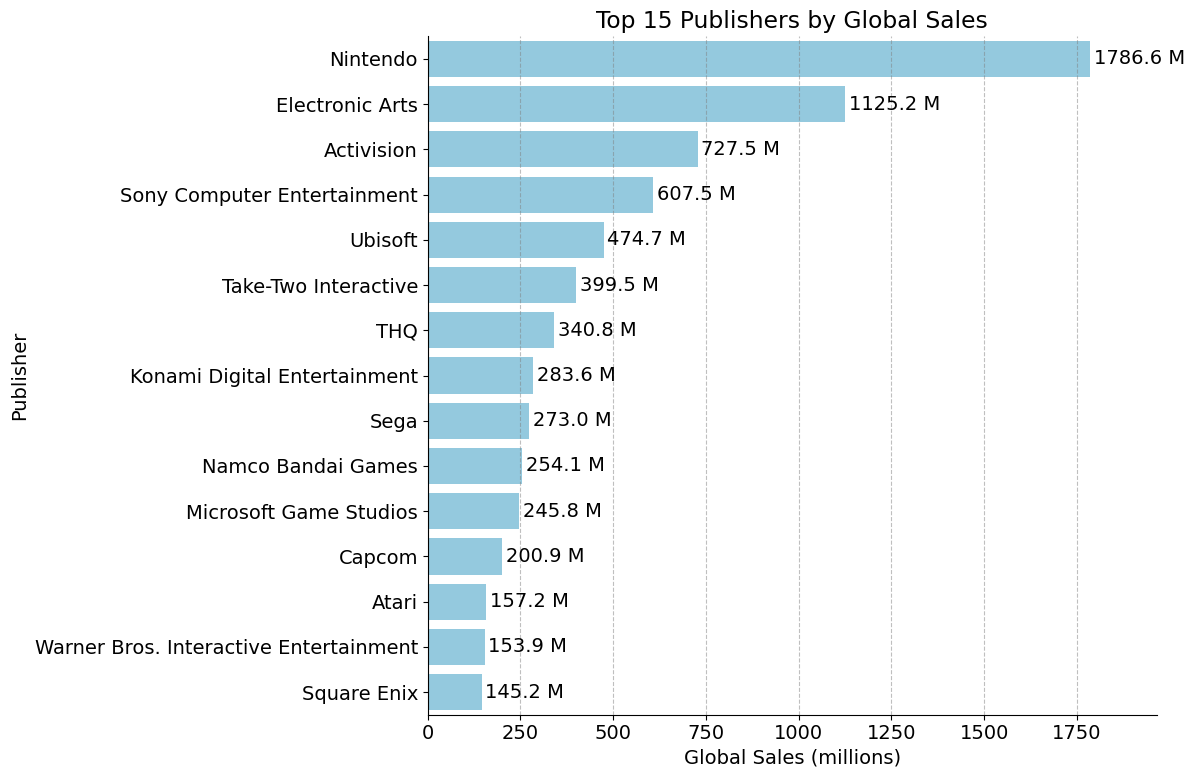

In [19]:
plt.figure(figsize=(12, 8))  # Increase the size of the graph for better readability
plt.rcParams.update({'font.size': 14, 'font.family':'sans-serif'})

# Calculation of global sales for each publisher and selection of the top 15
sum_values = datavg.groupby('Publisher')['Global_Sales'].sum()
top_publishers = sum_values.nlargest(15)

# Barplot creation
sns.barplot(x=top_publishers.values, y=top_publishers.index, color='skyblue', dodge=False)

# Adding Value Labels Beside Bars
max_value = top_publishers.values.max()
for i, value in enumerate(top_publishers.values):
    plt.text(value + 10, i, f'{value:.1f} M', va='center')

# Adding gridlines
plt.grid(axis='x', which='both', linestyle='--', color='gray', alpha=0.5)

# Axis labels and title
plt.xlabel('Global Sales (millions)')
plt.ylabel('Publisher')
plt.title('Top 15 Publishers by Global Sales')
plt.xlim(0, max_value * 1.1)
# Removing axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

plt.show()

In [20]:
import plotly.express as px

fig = px.scatter(datavg, 
                 x="Global_Sales", 
                 y="Genre", 
                 size="EU_Sales",  # Bubble size based on European sales
                 color="Genre",  # Optional: use color to further differentiate genres
                 hover_name="Name",  # Show the video game name on hover
                 title="Relationship Between Global Sales, Genre, and European Sales of Video Games")
fig.update_layout(showlegend=False)
fig.show()


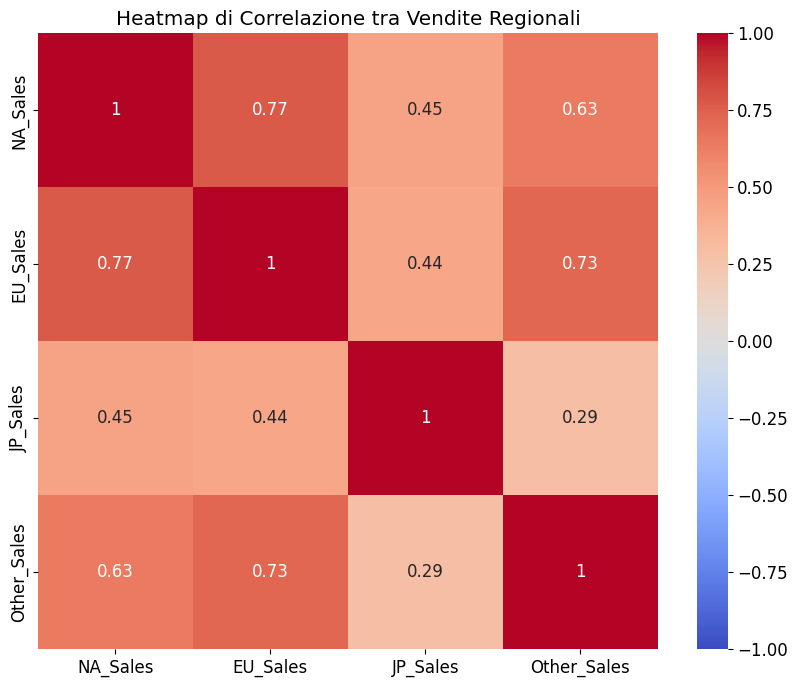

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcoliamo la correlazione tra le vendite nelle diverse regioni
corr = datavg[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].corr()

# Iniziamo la creazione della figura per il grafico
plt.figure(figsize=(10, 8))

# Creiamo la heatmap di correlazione
# Utilizziamo 'vmin' e 'vmax' per definire gli estremi della mappa di colori, assicurando che copra da -1 a 1
# Con 'center=0', centriamo il colore per indicare i valori di correlazione neutri
# 'annot=True' per visualizzare i valori della correlazione all'interno delle caselle
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)

# Aggiungiamo un titolo per descrivere meglio il contenuto del grafico
plt.title('Heatmap di Correlazione tra Vendite Regionali')

# Mostrare il grafico
plt.show()


Un altro dato molto interessante da analizzare riguarda il numero di giochi presenti nella nostra lista, rispetto alla piattaforma di appartenenza.

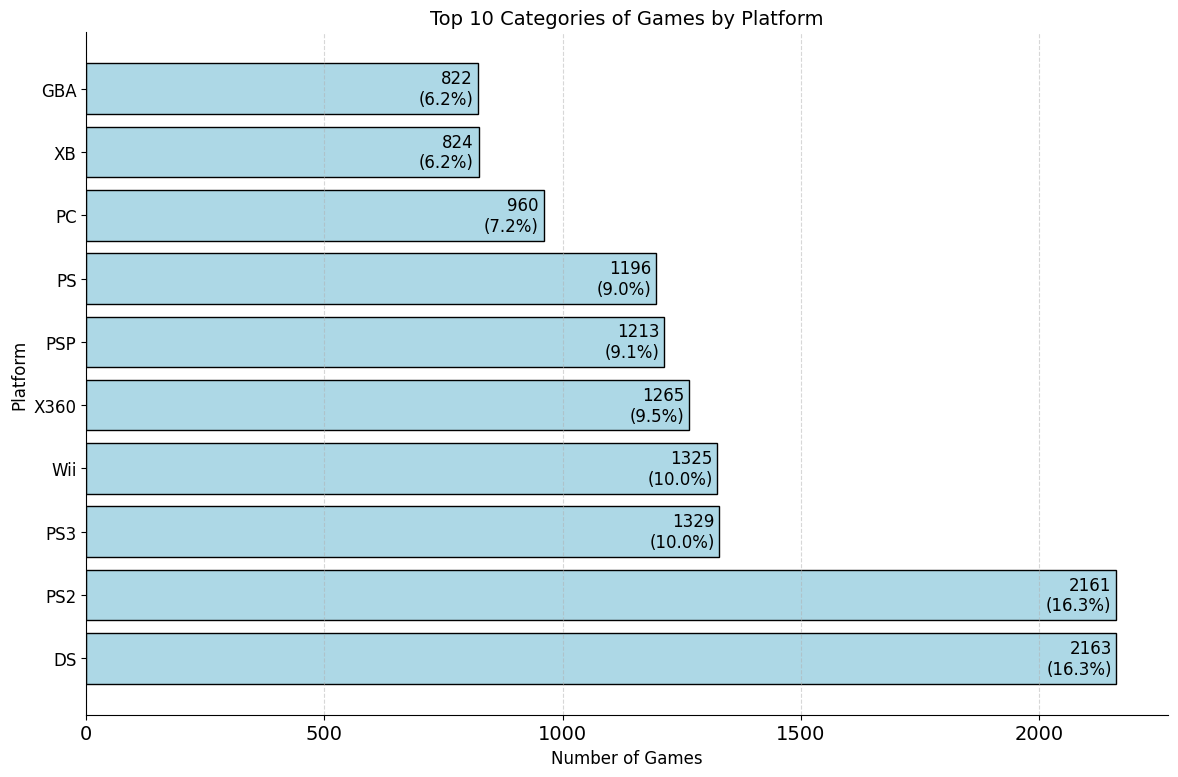

In [22]:
# Calcolo delle dimensioni per il grafico a barre
sizes = datavg.groupby('Platform')['Name'].count().nlargest(10)
labels = sizes.index

# Creazione del plot a barre orizzontali
plt.figure(figsize=(12, 8))
bars = plt.barh(labels, sizes, color='lightblue', edgecolor='black')

# Aggiunta delle etichette con percentuale e valore sopra le barre
for bar, size in zip(bars, sizes):
    percentage = (size / sizes.sum()) * 100
    plt.text(bar.get_width() - 10, bar.get_y() + bar.get_height()/2, f'{size}\n({percentage:.1f}%)',
             va='center', ha='right', color='black', fontsize=12)

# Titoli e etichette degli assi
plt.xlabel('Number of Games', fontsize=12)
plt.ylabel('Platform', fontsize=12)
plt.title('Top 10 Categories of Games by Platform', fontsize=14)

# Aggiungi griglia
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Rimuovere gli assi
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Aumenta la dimensione dei ticks sull'asse y
plt.tick_params(axis='y', which='major', labelsize=12)

plt.tight_layout()
plt.show()


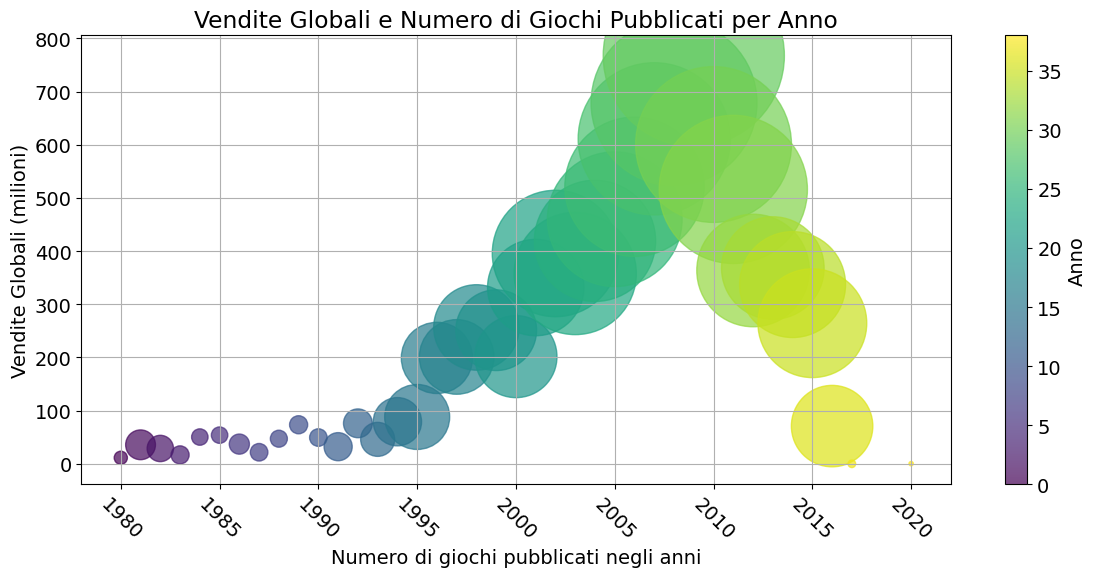

In [23]:
# Aggregazione dei dati per anno
sales_by_year = datavg.groupby('Year').agg({'Global_Sales':'sum', 'Name':'count'}).reset_index()

# Creazione del grafico a dispersione con Matplotlib
plt.figure(figsize=(12, 6))

# Crea una scala di colori basata sugli anni
colors = np.arange(len(sales_by_year))
plt.scatter(sales_by_year['Year'], sales_by_year['Global_Sales'], s=sales_by_year['Name']*10, c=colors, cmap='viridis', alpha=0.7)
plt.colorbar(label='Anno')  # Aggiunge la legenda per i colori

plt.xlabel('Numero di giochi pubblicati negli anni')
plt.ylabel('Vendite Globali (milioni)')
plt.title('Vendite Globali e Numero di Giochi Pubblicati per Anno')
plt.xticks(rotation=-45)
plt.grid(True)
plt.tight_layout()  # Regola automaticamente il layout per evitare sovrapposizioni
plt.show()


Il prossimo grafico ci mostra quali sono le piattaforme che hanno avuto le più alte vendite mondiali.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


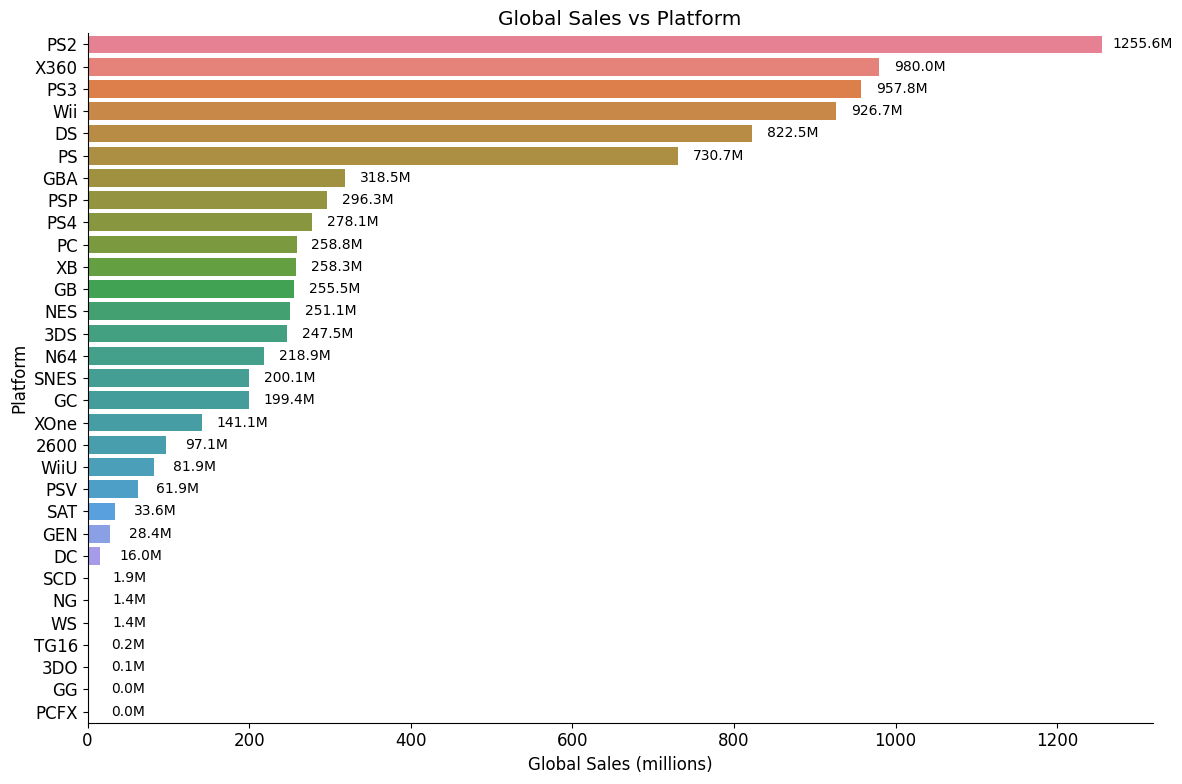

In [24]:
plt.figure(figsize=(12, 8))  # Aumentiamo la dimensione del grafico per una migliore leggibilità
plt.rcParams.update({'font.size': 12})  # Ingrandimento dei caratteri

# Calcolo delle vendite globali per ogni piattaforma e ordinamento decrescente
sum_values = datavg.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

# Creazione del plot a barre con hue impostato su y
sns.barplot(x=sum_values.values, y=sum_values.index, hue=sum_values.index, dodge=False)

# Aggiunta delle etichette di valore sopra le barre
for i, value in enumerate(sum_values.values):
    plt.text(value + 50, i, f'{value:.1f}M', ha='center', va='center', fontsize=10, color='black')

# Etichette degli assi e titolo
plt.xlabel('Global Sales (millions)')
plt.ylabel('Platform')
plt.title('Global Sales vs Platform')

# Rimuovere gli assi
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Nascondere la legenda
plt.legend().remove()

plt.tight_layout()
plt.show()


E' bene notare come le vendite maggiori si abbiano da vecchie piattaforme, mentre macchine più moderne presentano vendite mondiali molto più contenute.

Adesso passiamo ad alcune analisi temporali, molto utili per studiare l'andamento del tempo dei dati. Iniziamo agendo sulla colonna 'Year', che come abbiamo visto ad inizio del progetto presenta dei dati float, che vanno trasformati in integer per consentire l'uso.

In [25]:
"""year type transformation in integer"""

datavg['Year'] = datavg['Year'].astype(int)
datavg = datavg.sort_values('Year')

years = datavg['Year']

Abbiamo diversi valori di vendita, e Global_Sales comprende - ovviamente - tutti gli altri. Per questo andremo ad analizzarlo da solo.

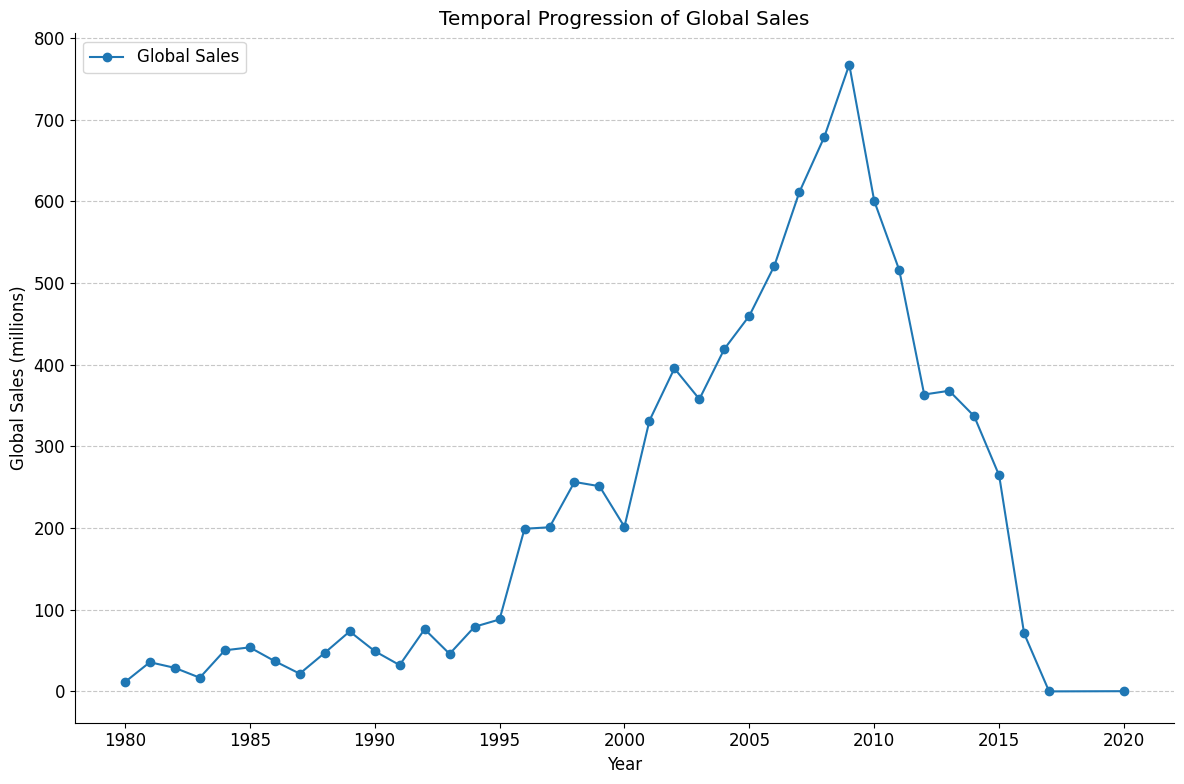

In [26]:
# Creiamo una figura più grande per una migliore leggibilità
plt.figure(figsize=(12, 8))

# Utilizziamo un grafico a linee anziché a barre per una visualizzazione temporale più chiara
plt.plot(datavg.groupby('Year')['Global_Sales'].sum(), marker='o', linestyle='-', label='Global Sales')

# Aggiungiamo una griglia per una migliore lettura dei valori
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Etichette degli assi e titolo del grafico
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.title('Temporal Progression of Global Sales')

# Aggiungiamo una legenda e posizioniamola in un punto migliore del grafico
plt.legend(loc='upper left')

# Rimuoviamo gli assi sul lato destro e superiore per una migliore pulizia del grafico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Impossibile non notare il boom del 2006, circondato da anni fiscali nella media. Particolari anche i dati dal 2016 al 2020, che non riportano alcun dato. Ricordiamoci sempre che stiamo analizzando un dataset contenente una classifica, e che quindi la discriminante non è l'anno ma le vendite. Inoltre questi dati potrebbero riferirsi a vecchie classifiche.

Passiamo ad analizzare i mercati delle diverse macrozone.

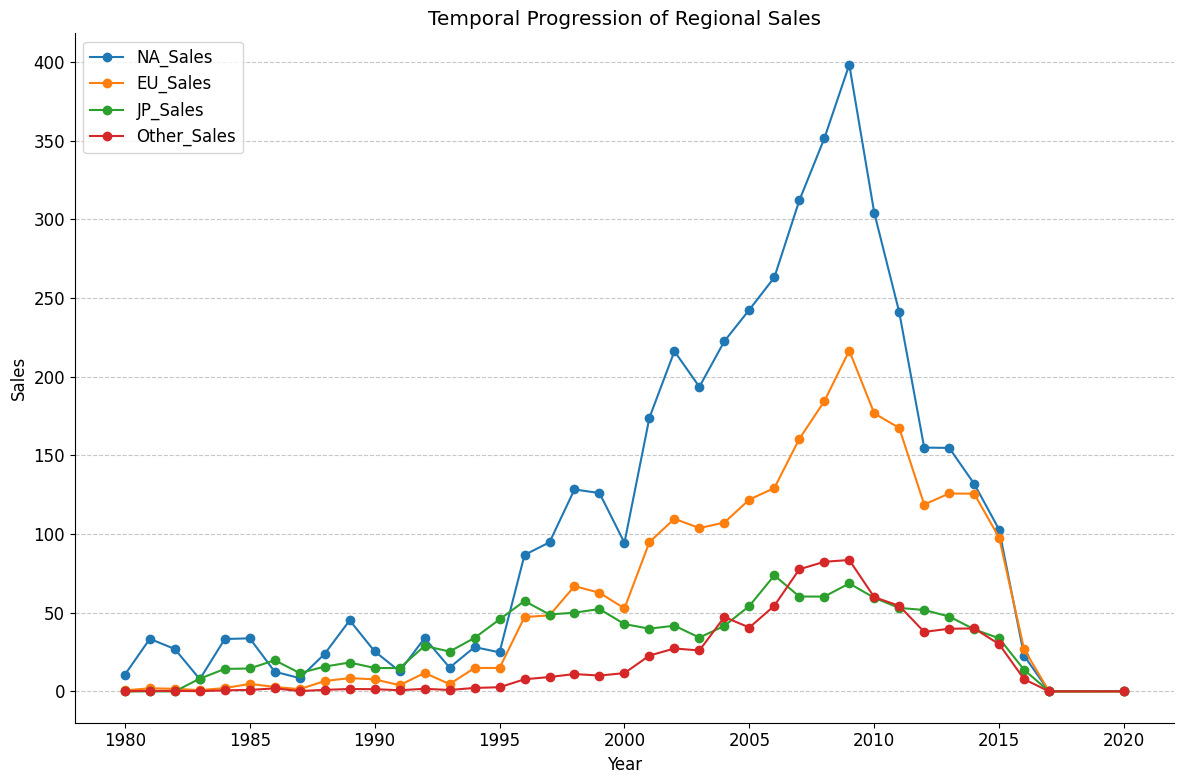

In [27]:
# Creiamo una figura più grande per una migliore leggibilità
plt.figure(figsize=(12, 8))

# Grafico a linee per rappresentare la progressione temporale delle vendite regionali
plt.plot(datavg.groupby('Year')['NA_Sales'].sum(), marker='o', linestyle='-', label='NA_Sales')
plt.plot(datavg.groupby('Year')['EU_Sales'].sum(), marker='o', linestyle='-', label='EU_Sales')
plt.plot(datavg.groupby('Year')['JP_Sales'].sum(), marker='o', linestyle='-', label='JP_Sales')
plt.plot(datavg.groupby('Year')['Other_Sales'].sum(), marker='o', linestyle='-', label='Other_Sales')

# Aggiungiamo una griglia per una migliore lettura dei valori
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Etichette degli assi e titolo del grafico
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Temporal Progression of Regional Sales')

# Aggiungiamo una legenda e posizioniamola in un punto migliore del grafico
plt.legend(loc='upper left')

# Rimuoviamo gli assi sul lato destro e superiore per una migliore pulizia del grafico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Possiamo da subito notare come NA_sales (valori non applicabili agli altri mercati) e EU siano tra i mercati che più spiccano nel grafico, soprattutto durante il boom del 2006 già percepito nel precedente grafico.

Un altra interessante visualizzazione temporale può essere quella delle piattaforme.

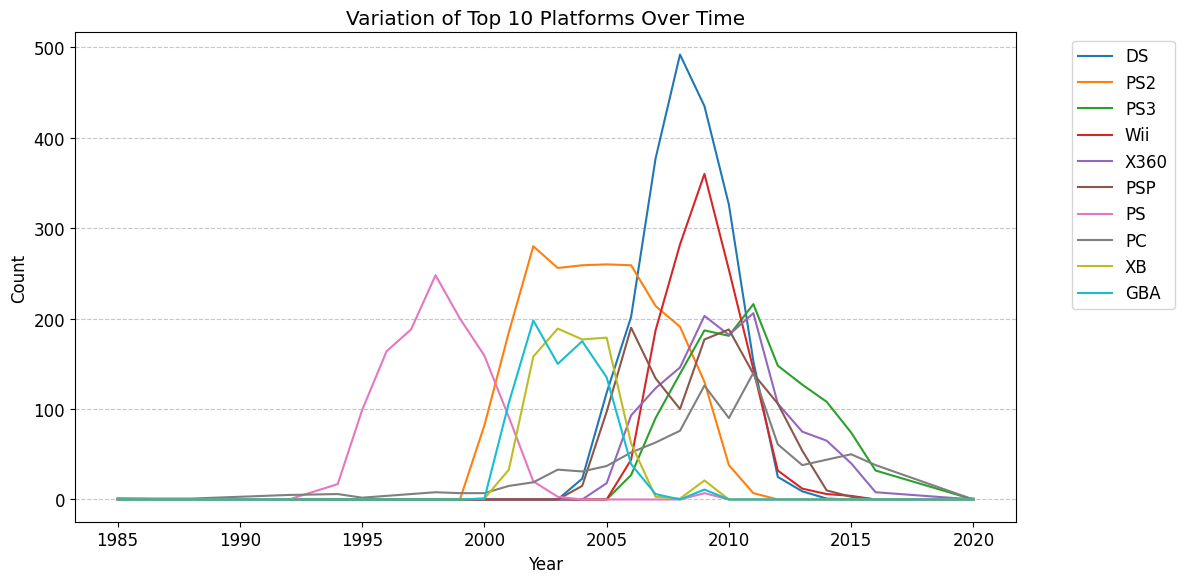

In [28]:
# Seleziona i primi dieci platform in base al conteggio dei giochi
top_10_platforms = datavg['Platform'].value_counts().nlargest(10).index

# Filtra i dati per i primi dieci platform
top_10_data = datavg[datavg['Platform'].isin(top_10_platforms)]

# Raggruppa per anno e platform e calcola il conteggio dei giochi per ogni combinazione
platform_counts = top_10_data.groupby(['Year', 'Platform']).size().unstack().fillna(0)

# Crea il grafico a linea con colori distinti per ogni platform
plt.figure(figsize=(12, 6))
# Aggiungiamo una griglia per una migliore lettura dei valori
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Lista di colori per rendere distinti i platform nel grafico
colors = plt.cm.tab10.colors

for i, platform in enumerate(top_10_platforms):
    plt.plot(platform_counts.index, platform_counts[platform], label=platform, color=colors[i])

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Variation of Top 10 Platforms Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Posiziona la legenda fuori dal grafico

plt.tight_layout()
plt.show()


---

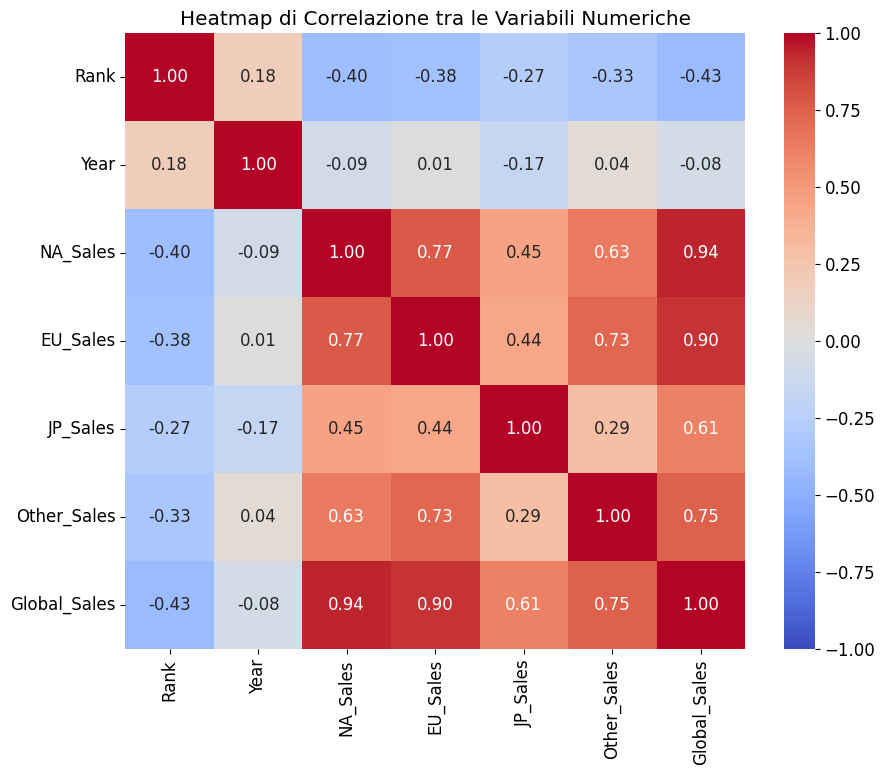

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selezione dei dati numerici per calcolare la correlazione
numeric_data = datavg.select_dtypes(include=[float, int])

# Calcolo della matrice di correlazione
corr_matrix = numeric_data.corr()

# Creazione della heatmap di correlazione con una scala di colori che aiuti a interpretare meglio i dati
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", center=0, vmin=-1, vmax=1)

# Aggiunta di un titolo più descrittivo per spiegare chiaramente il contenuto della heatmap
plt.title('Heatmap di Correlazione tra le Variabili Numeriche')

plt.show()

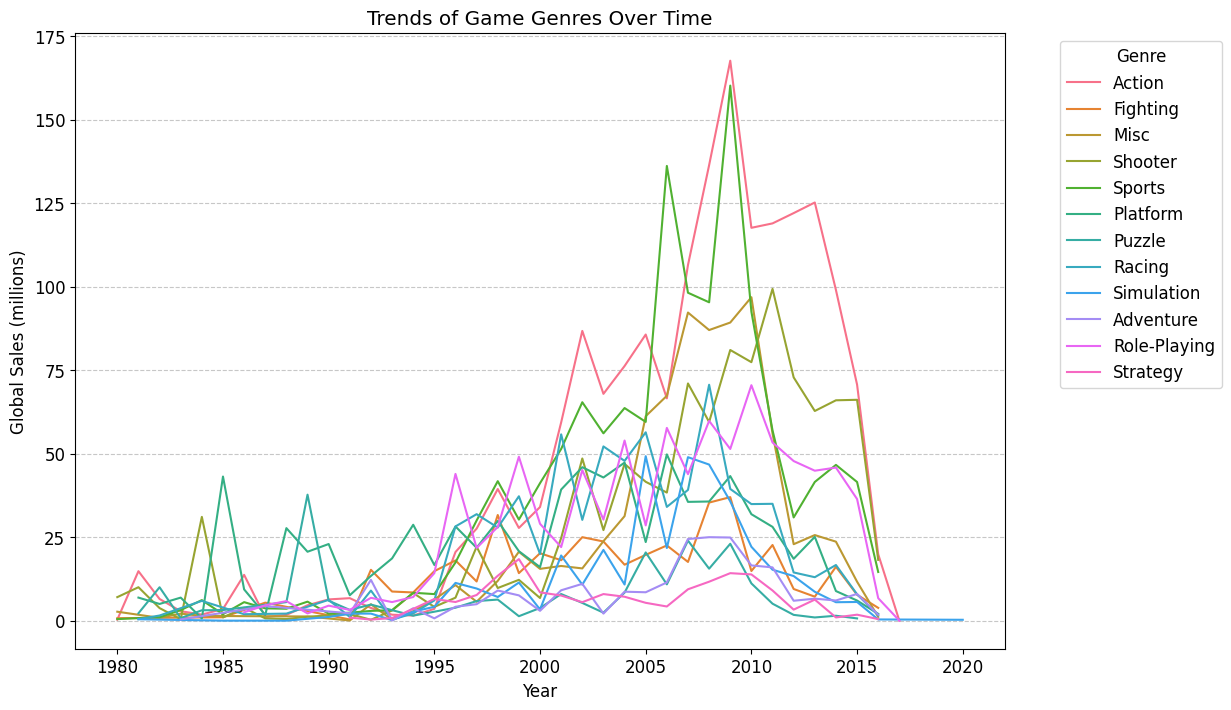

In [30]:
# Analisi delle tendenze dei generi di giochi nel tempo
genre_trends = datavg.groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=genre_trends, x='Year', y='Global_Sales', hue='Genre')
plt.title('Trends of Game Genres Over Time')
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


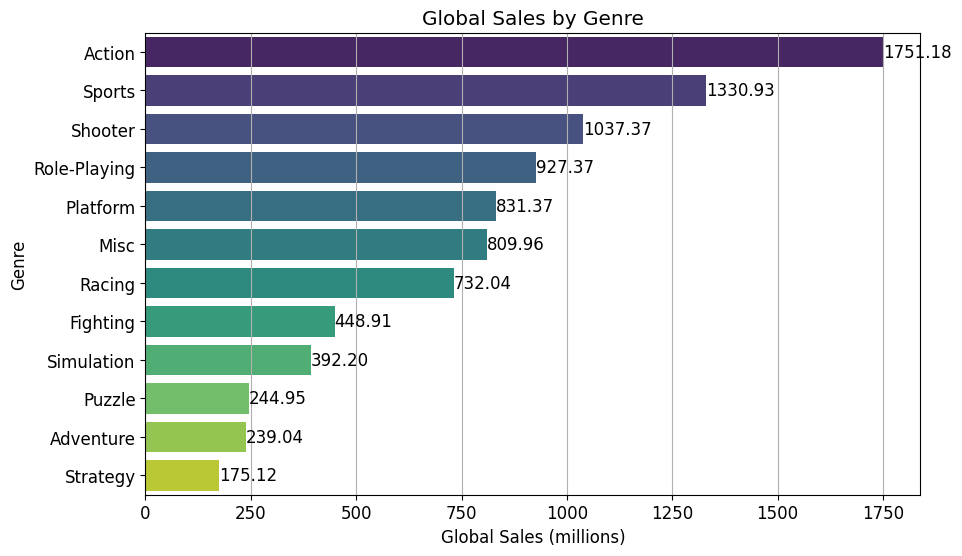

In [31]:
# Calcolo delle vendite globali per genere
genre_sales = datavg.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_sales.values, y=genre_sales.index, hue=genre_sales.index, palette='viridis', dodge=False, legend=False)

# Aggiunta delle etichette sulle barre
for i, value in enumerate(genre_sales.values):
    plt.text(value + 0.1, i, f'{value:.2f}', va='center')

plt.title('Global Sales by Genre')
plt.xlabel('Global Sales (millions)')
plt.ylabel('Genre')

# Aggiunta della griglia
plt.grid(axis='x')

plt.show()

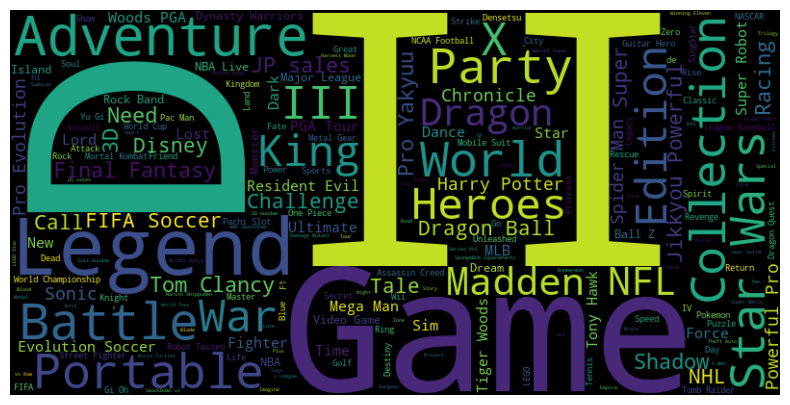

In [32]:
# Crea una stringa lunga con tutti i titoli
titles = ' '.join(datavg['Name'])

# Genera una WordCloud
wordcloud = WordCloud(width=800, height=400).generate(titles)

# Visualizza la WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
